In [68]:
# Weight decay
# Some standard techniques for regularizing models.
# From now, we can assume that we already have as much high-quality data as our resources permit
# and focus on regularization techniques.

In [69]:
# The most common method for ensuring a small weight vector is 
# to add its norm as a penalty term to the problem of minimizing the loss.
# In contrast to feature selection, weight decay offers us a 'continuous' mechanism for adjusting the complexity of a ftn.
# Often, we do not regularize the bias term of a network's output layer. 

In [70]:
# High-dimensional Linear Regression
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

In [71]:
# To make the effects of overfitting pronounced, we can increase the dimensionality 
# of our problem to 'd = 200' and work with a small training set containing only 20 examples.
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05 # true weights and bias
train_data = d2l.synthetic_data(true_w, true_b, n_train) # tuple of (20, 200), (20, 1)
train_iter = d2l.load_array(train_data, batch_size) # iterator of batch size 5
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False) # iterator of batch size 5

# Initializing Model Parameters
def init_params():
    w = tf.Variable(tf.random.normal(shape=(num_inputs, 1), mean=0))
    b = tf.Variable(tf.zeros(shape=(1,)))
    return [w, b] # tuple of tensors of size (200, 1), (1, ), respectively

# Defining L_2 Norm Penalty
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

# Defining the Training Loop
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
    xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # The L2 norm penalty term has been added, and broadcasting
                # makes 'l2_penalty(w)' a vector whose size is 'batch_size'.
                l = loss(net(X), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            d2l.sgd([w, b], grads, lr, batch_size)
        if (epoch + 1) % 5 ==0:
            animator.add(epoch + 1, (
                d2l.evaluate_loss(net, train_iter, loss),
                d2l.evaluate_loss(net, test_iter, loss)
            ))
    print('L2 norm of w:', tf.norm(w).numpy())

L2 norm of w: 13.150859


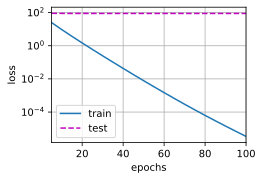

In [72]:
# Training without Regularization
# Can be understood as overfitting.
train(lambd=0)

L2 norm of w: 0.36913916


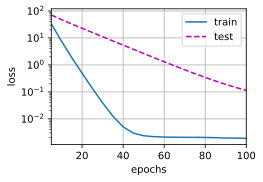

In [73]:
# Using Weight Decay
train(lambd=3)

In [77]:
# Concise Implementation
def train_concise(wd):
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(wd)
    ))
    # 왜 'input_shape' 옵션을 다음과 같이 설정했는지 직접 코드를 실행해보면 알 수 있다.
    # 'net.build()' ftn을 사용했기 때문에 아래의 'w', 'b'를 정의할 수 있다.
    net.build(input_shape=(1, num_inputs)) 
    w, b = net.trainable_variables
    loss = tf.keras.losses.MeanSquaredError() # 직접 해보면 '1/2가 곱해지지 않음을 확인할 수 있습니다.'
    num_epochs, lr = 100, 0.003
    trainer = tf.keras.optimizers.SGD(learning_rate=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
    xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # 'tf.keras' requires retrieving and adding the losses from
                # layers manually for custom training loop.
                l = loss(net(X), y) + net.losses # the latter refers to the regularization term. Note that '1/2' is not multiplied to both terms.
            grads = tape.gradient(l, net.trainable_variables)
            trainer.apply_gradients(zip(grads, net.trainable_variables))
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), 
            d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(net.get_weights()[0]).numpy())

L2 norm of w: 1.3299515


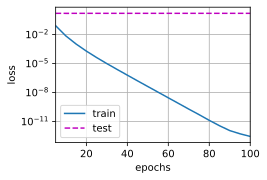

In [79]:
# Training w/o regularization
train_concise(0)

L2 norm of w: 0.03560127


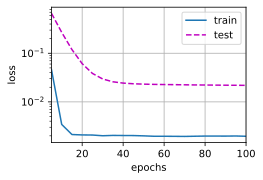

In [81]:
# Training w/ regularization
train_concise(4)